In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, norm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *
from joblib import Parallel, delayed
import multiprocessing

from PIL import Image



Populating the interactive namespace from numpy and matplotlib


In [2]:
pad_x_im = Image.open("pad_u_x.tif") 
pad_x =  np.array(pad_x_im) 

pad_y_im = Image.open("pad_u_y.tif") 
pad_y =  np.array(pad_y_im) 

annulus_x_im = Image.open("annulus_u_x.tif")
annulus_x =  np.array(annulus_x_im) 

annulus_y_im = Image.open("annulus_u_y.tif")
annulus_y = np.array(annulus_y_im) 

pad_im = Image.open('pads/padmask.tif')
pad_imarray = np.array(pad_im) 

annulus_im = Image.open('annulus/annulusmask.tif')
annulus_imarray = np.array(annulus_im)

annulus_mask = annulus_imarray == 0
annulus_distance = -ndimage.distance_transform_edt(annulus_mask) + ndimage.distance_transform_edt(1 - annulus_mask)
annulus_distance = annulus_distance.flatten()

pad_mask = pad_imarray == 0
pad_distance = -ndimage.distance_transform_edt(pad_mask) + ndimage.distance_transform_edt(1 - pad_mask)
pad_distance = pad_distance.flatten()

N = 160
M = 120


In [3]:
spacing = 2
_CUTOFF  = 10


x_obs_positions = np.arange(0,N,spacing)
y_obs_positions = np.arange(0,M,spacing)

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

coords = [[ [x,y] for x in x_obs_positions] for y in y_obs_positions] 
coords = np.array([item for sublist in coords for item in sublist])

# generate the conditions

distancefun = np.array([annulus_distance.reshape((M,N))[a[1],a[0]] for a in coords]) # stupid but works


condition_inside = distancefun<=0
condition_outside = (distancefun>0) * (distancefun<=_CUTOFF)

# obtain the observations

obs_x_in_annulus = np.array([annulus_x[a[1],a[0]] for a,cond in zip(coords,condition_inside)if cond] )
obs_x_out_annulus = np.array([annulus_x[a[1],a[0]] for a,cond in zip(coords,condition_outside)if cond] )

obs_y_in_annulus = np.array([annulus_y[a[1],a[0]] for a,cond in zip(coords,condition_inside)if cond] )
obs_y_out_annulus = np.array([annulus_y[a[1],a[0]] for a,cond in zip(coords,condition_outside)if cond] )

x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)



G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx*spacing,dy*spacing,loworder = True)

Size of the problem is 1269


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [4]:
N_SOLUTIONS = 24
gamma_vals = np.logspace(-8, -2.5, N_SOLUTIONS)


# Coords are 1:100 in each direction
# annulus centered
# inner radius 20
# outer radius 30
# boundary radius 35

gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma_xz = Variable(n_in)
sigma_yz = Variable(n_in)
predicted_in_x = G_in_in_xx * sigma_xz + G_in_in_xy * sigma_yz
predicted_out_x = G_out_in_xx * sigma_xz + G_out_in_xy * sigma_yz
predicted_in_y = G_in_in_yx * sigma_xz + G_in_in_yy * sigma_yz
predicted_out_y = G_out_in_yx * sigma_xz + G_out_in_yy * sigma_yz


error = sum_squares(obs_x_in_annulus - predicted_in_x) + sum_squares(obs_x_out_annulus - predicted_out_x) + \
    sum_squares(obs_y_in_annulus - predicted_in_y) + sum_squares(obs_y_out_annulus - predicted_out_y)

forceconstraints = [sum_entries(sigma_xz)==0, sum_entries(sigma_yz)==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma_yz) - mul_elemwise(y_in-y_center,sigma_xz))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []
regularity_penalty = tvnorm2d(sigma_xz, Dx, Dy) + tvnorm2d(sigma_yz, Dx, Dy)

objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_xz_values = []
sigma_yz_values = []

u_x_values = []
u_y_values = []

In [5]:
#num_cores = multiprocessing.cpu_count() - 4
num_cores = 2

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-7, reltol = 1e-6,
                   abstol = 1e-7)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_xz_values.append(sigma_xz.value)
    sigma_yz_values.append(sigma_yz.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside].flat = sigma_xz.value.reshape((n_in,))
    s_y[condition_inside].flat = sigma_yz.value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside].flat = predicted_in_x.value
    u_x[condition_outside].flat = predicted_out_x.value
    u_y[condition_inside].flat = predicted_in_y.value
    u_y[condition_outside].flat = predicted_out_y.value
    
    return np.array([sigma_xz.value, sigma_yz.value]).T, error.value, regularity_penalty.value, val

    return np.array([s_x, s_y]).T,  error.value, regularity_penalty.value, val


#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)
annulus_results = [invert_one(val) for val in gamma_vals]

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  1e+03  1e+01  2e+01  1e+00
 1:  6.3737e-03 -2.6702e-02  4e+01  6e-01  8e-01  2e-01
 2:  1.0372e-04 -2.6302e-04  4e-01  6e-03  8e-03  2e-03
 3:  7.6031e-06 -2.5005e-06  5e-03  7e-05  1e-04  2e-05
 4:  4.3427e-06  8.8944e-08  5e-04  1e-05  2e-05  1e-07
 5:  1.2048e-07  1.0467e-07  4e-08  2e-07  2e-07  4e-08
 6:  1.1582e-07  1.1476e-07  2e-09  7e-09  1e-08  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  1e+03  1e+01  2e+01  1e+00
 1:  6.3777e-03 -2.6702e-02  4e+01  6e-01  8e-01  2e-01
 2:  1.0847e-04 -2.6301e-04  4e-01  6e-03  8e-03  2e-03
 3:  1.2338e-05 -2.4890e-06  6e-03  9e-05  1e-04  2e-05
 4:  6.0021e-06  7.6580e-08  6e-04  2e-05  2e-05  9e-08
 5:  1.2639e-07  8.9323e-08  8e-08  3e-07  4e-07  6e-08
 6:  1.1654e-07  1.1400e-07  5e-09  1e-08  2e-08  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0

 8:  8.8880e-07  8.7702e-07  2e-08  5e-08  7e-08  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  1e+03  1e+01  2e+01  1e+00
 1:  4.0640e-02 -2.6182e-02  5e+01  7e-01  9e-01  2e-01
 2:  3.0390e-02 -2.9745e-04  4e+00  9e-02  1e-01  3e-03
 3: -6.3363e-05 -6.3350e-05  2e-04  1e-03  2e-03  5e-04
 4:  4.4782e-06 -3.3483e-08  9e-06  2e-05  4e-05  5e-06
 5:  1.6582e-06  1.0361e-06  1e-06  3e-06  5e-06  6e-07
 6:  1.4008e-06  1.3073e-06  2e-07  5e-07  7e-07  9e-08
 7:  1.3915e-06  1.3485e-06  8e-08  2e-07  3e-07  3e-08
 8:  1.3790e-06  1.3628e-06  3e-08  7e-08  1e-07  9e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  1e+03  1e+01  2e+01  1e+00
 1:  6.4073e-02 -2.5816e-02  5e+01  7e-01  1e+00  2e-01
 2:  4.3480e-02 -3.8900e-04  5e+00  1e-01  2e-01  3e-03
 3: -1.7198e-04 -1.0686e-04  3e-04  2e-03  3e-03  8e-04
 4:  6.2320e-06 -1.2780e-07  1e-05  4e-05  6e-05  8e-06
 5: 

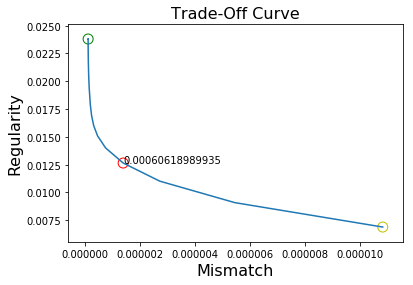

In [7]:
data_error = [res[1] for res in annulus_results]
reg_error = [res[2] for res in annulus_results]
lvals = [res[3] for res in annulus_results]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

plt.plot( data_error, reg_error)
plt.scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
plt.scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
plt.scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='y')

plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)
plt.text(data_error[best],reg_error[best],lvals[best])

In [8]:
results2 = [list(solution) for solution in annulus_results]

for solution in results2:

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside] = solution[0][0][:,0]
    s_y[condition_inside] = solution[0][0][:,1]
    
    solution.insert(0, [ s_x.reshape((len(y_obs_positions),len(x_obs_positions))), 
                   s_y.reshape((len(y_obs_positions),len(x_obs_positions))), 
                  x_obs_positions,y_obs_positions])
    #_ = solution.pop(1)

import pickle
import gzip

with gzip.open('results/annulus_tviso2.gz','wb') as f:
    pickle.dump(results2,f)